# 计算指定距离范围内最近的商店（Business）

### 该 Notebook 对应的博客[链接](XXX)


当给出用户的地理坐标（纬度，精度）时，如何快速获取到离该用户最近的商店？

KNN（K Nearest Neighbors）算法跟我们的需求有点像，都涉及到求离某一点最近的点，只不过它一般是用来基于这些最近的点，投票决定该点的类别。咋看起来，KNN 不能满足我们的需求，但仔细一想，`KNN 跟我们的需求本质上是一样的，都需要计算距离（多种定义，常见的是欧氏距离）。当我们查找到离用户最远距离为 D 的所有商店时，K 这个值也就确定了；当我们找到 K 个最近的点时，离用户最远的距离 D 也就确定了。`

不过 KNN 算法虽然简单，但`高效`计算就不是一件容易的事了。简单拿一个点跟所有点都计算一次距离在大数据情况下是不大可行的。对此，KNN 使用 KD 树来解决这个问题。关于 KD 树详细可参考博客 [KD 树算法之思路篇](https://www.joinquant.com/post/ca173aea7f0e5ba3d711793e38902232?f=stydy&m=math)、[KD 树算法之详细篇](https://www.joinquant.com/post/1ab44d756c00ac7bc5e9de3a90ac4893?f=stydy&m=math)。下文也将使用 KD 树来查找离用户最近的商店。

最后，这里还有一个问题就是用户和商店（Business）的地理坐标都是经纬度，直接计算直线距离是不行的，而且这些经纬度能够传入到 KNN 算法中计算。这些处理我们在后文中进行说明。

In [13]:
import numpy as np
import pandas as pd
from scipy import spatial
import matplotlib.pyplot as plt

## 1. Las Vegas 版图

Las Vegas 的版图宽大概为 31.55 公里，高大概为 27.66 公里，见如下两谷歌地图截图：

![](images/knn/las_vegas_wide.png)

![](images/knn/las_vegas_height.png)


## 2. 加载数据

In [14]:
yelp_lv_bizes = pd.read_csv('../../dataset/las_vegas/business/las_vegas_business_preprocessed_with_db_id.csv')

In [15]:
len(yelp_lv_bizes)

26777

In [16]:
yelp_lv_bizes[:5]

,db_id,business_id,stars,review_count,latitude,longitude,city,checkin_count,review_count_scaled,checkin_count_scaled,popularity
0,4,--9e1ONYQuAa-CB_Rrw7Tw,4.0,1451,36.1232,-115.169,Las Vegas,2568.0,0.196793,0.019461,0.096371
1,11,--DdmeR16TRb3LsjG0ejrQ,3.0,5,36.1143,-115.171,Las Vegas,30.0,0.000272,0.000227,0.000297
2,12,--e8PjCNhEz32pprnPhCwQ,3.5,19,36.1589,-115.133,Las Vegas,1.0,0.002175,0.000008,0.000895
3,29,--o5BoU7qYMALeVDK6mwVg,3.5,6,36.1016,-115.132,Las Vegas,0.0,0.000408,0.000000,0.000167
4,33,--q7kSBRb0vWC8lSkXFByA,4.0,7,36.0167,-115.173,Las Vegas,107.0,0.000544,0.000811,0.000885


## 3. 商店地理分布情况

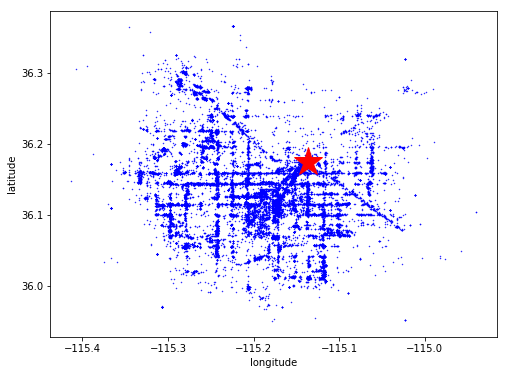

In [17]:
# Las Vegas 中心点经纬度，参考链接：https://tools.wmflabs.org/geohack/geohack.php?pagename=Las_Vegas&params=36_10_30_N_115_08_11_W_type:city(583756)_region:US-NV
lat_center = 36.175
lon_center = -115.136389

# 定义经纬度范围
lon_min, lon_max = lon_center - 0.28, lon_center + 0.2
lat_min, lat_max = lat_center - 0.23, lat_center + 0.2

# 选择定义范围内的点
scoped_bizes = yelp_lv_bizes[(yelp_lv_bizes.longitude > lon_min) & \
                             (yelp_lv_bizes.longitude < lon_max) & \
                             (yelp_lv_bizes.latitude > lat_min) & \
                             (yelp_lv_bizes.latitude < lat_max)]

# 绘图
scoped_bizes.plot(kind='scatter', x='longitude', y='latitude', color='b', s=.2, figsize=(8,6))

# 添加上中心点
plt.plot(lon_center, lat_center, 'r*', markersize=30)

## 3. 计算指定范围内相邻的商店

这部分主要是参考了 [KD-Tree 2 Real Distance](https://github.com/qingkaikong/blog/tree/master/2017_33_kdtree_2_real_distance)、[How to Convert KD-Tree Distance from Query to Kilometers](https://stackoverflow.com/questions/43020919/scipy-how-to-convert-kd-tree-distance-from-query-to-kilometers-python-pandas) 两篇资料。前篇资料是在后者基础上写成的。`这部分的代码我们就直接摘录自前篇文档。`

### 3.1 坐标转换

因为我们不能直接计算地球上两点的直线距离，所以需要先将经纬度转换为地心坐标系下的坐标。下边是[维基](https://zh.wikipedia.org/wiki/%E5%9C%B0%E5%BF%83%E5%9C%B0%E5%9B%BA%E5%9D%90%E6%A0%87%E7%B3%BB)关于地心坐标系的描述：
> 地心地固坐标系（Earth-Centered, Earth-Fixed，简称ECEF）简称地心坐标系，是一种以地心为原点的地固坐标系（也称地球坐标系），是一种笛卡儿坐标系。原点 O (0,0,0)为地球质心，z 轴与地轴平行指向北极点，x 轴指向本初子午线与赤道的交点，y 轴垂直于xOz平面(即东经90度与赤道的交点)构成右手坐标系。

如何转换经纬度为地心坐标系下坐标看下图就比较清晰了：
![](images/knn/ecef.png)[图片链接](https://zh.wikipedia.org/wiki/%E5%9C%B0%E5%BF%83%E5%9C%B0%E5%9B%BA%E5%9D%90%E6%A0%87%E7%B3%BB) 

代码如下：

In [18]:
from math import *

In [19]:
def to_Cartesian(lat, lng):
    '''
    function to convert latitude and longitude to 3D cartesian coordinates
    '''
    R = 6371 # radius of the Earth in kilometers

    x = R * cos(lat) * cos(lng)
    y = R * cos(lat) * sin(lng)
    z = R * sin(lat)
    return x, y, z

### 3.2 距离转换
地理坐标转换后，还需要把地表距离转换为地心坐标系下的距离，这样才可以利用 KD 树来计算指定范围内的商店，代码如下：

In [20]:
def rad2deg(rad):
    '''
    function to convert radian to degree
    '''
    degree = rad/2/np.pi * 360
    return(degree)

def kmToDIST(x):
    '''
    function to convert real distance in km to cartesian distance 
    '''
    R = 6371 # earth radius
    gamma = 2*np.arcsin(x/2./R) 

    dist = 2*R*rad2deg(sin(gamma / 2.))
    return(dist)

### 3.3 查找离用户最近的商店
完成以上两步后，就可以用 KD 树来计算指定范围内的商店了，代码如下：

In [21]:
# 定义地表地理范围半径（单位：km）
DIST = 5

In [22]:
# 转换经纬度为地心坐标系下坐标
x, y, z = zip(*map(to_Cartesian, yelp_lv_bizes.latitude.values, yelp_lv_bizes.longitude.values))
x_ref, y_ref, z_ref = to_Cartesian(lat_center, lon_center) # Las Vegas 中心点

In [23]:
# 转换地表距离为地心坐标系下的距离
dist = kmToDIST(DIST)

# 创建一个 3D KD 树
coordinates = list(zip(x, y, z))
tree = spatial.cKDTree(coordinates)

# 获取指定范围内和中心点（lat_center, lon_center）相邻的 business
indexes = tree.query_ball_point((x_ref, y_ref, z_ref), dist)
len(indexes)

10267

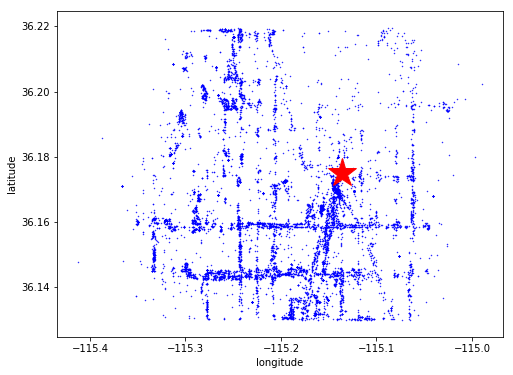

In [24]:
# 过滤出指定范围内的商店
scoped_bizes = yelp_lv_bizes[yelp_lv_bizes.index.isin(indexes)]
scoped_bizes = scoped_bizes[(scoped_bizes.longitude > lon_min) & \
                            (scoped_bizes.longitude < lon_max) & \
                            (scoped_bizes.latitude > lat_min) & \
                            (scoped_bizes.latitude < lat_max)]

# 绘图
scoped_bizes.plot(kind='scatter', x='longitude', y='latitude', color='b', s=.2, figsize=(8,6))

# 添加上中心点
plt.plot(lon_center, lat_center, 'r*', markersize=30)